### Table of Contents

* [I. Libraries and Modules](#chapter1)
* [II. Collaborative filtering-based Recommender System](#chapter2)
    * [a. Data Preprocessing](#section_2_1)
    * [b. Matrix Factorization](#section_2_2)
    * [c. Recommendations](#section_2_3)
* [III. Hybrid Recommender System](#chapter3)
    * [a. Tweets Scraping](#section_3_1)
    * [b. Sentiment Analysis](#section_3_2)
    * [c. Dataset Pre-processing](#section_3_3)
    * [d. Neural Embedding](#section_3_4)
    * [e. Recommendations](#section_3_5)


## I. Libraries and Modules <a class="anchor" id="chapter1"></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import tweepy
import string

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
plt.rcParams["figure.figsize"] = (10,6)

import math
import sklearn.metrics

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## II. Collaborative filtering-based Recommender System <a class="anchor" id="chapter2"></a>

### a. Data Preprocessing <a class="anchor" id="chapter2_1"></a>

In [ ]:
data_df = pd.read_csv('u.data', sep = '\t', names= ['user_id', 'item_id','rating','timestamp'])
data_df

user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]

In [ ]:
data_df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [ ]:
data_df_pivot= data_df.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
data_df_pivot

item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
939       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   
940       0.0   0.0   0.0   2.0   0.0   0.0   4.0   5.0   3.0   0.0  ...   
941       5.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   
942       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
943       0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
939       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
940       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
941       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
942       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
943       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[943 rows x 1682 columns]

### b. Matrix Factorization <a class="anchor" id="chapter2_2"></a>

In [ ]:
 def NMF(pivoted_df, num_latent_features):
    from sklearn.decomposition import NMF

    array = pivoted_df.to_numpy()
    model = NMF(n_components=num_latent_features, init='random', random_state=0)
    W = model.fit_transform(array)
    H = model.components_

    ratings_predicted_array=np.dot(W,H)
    ratings_predicted_df = pd.DataFrame(ratings_predicted_array, columns = pivoted_df.columns)

    mse = sklearn.metrics.mean_squared_error(pivoted_df, ratings_predicted_df)
    rmse = math.sqrt(mse)

    print(f'''
    Users latent features shape: {W.shape}
    Movies latent feature shape: {H.shape}
    RMSE with latent feature size of {num_latent_features}: {rmse}
          ''')
    return ratings_predicted_df

In [ ]:
ratings_predicted_df_5 = NMF(data_df_pivot,5)


    Users latent features shape: (943, 5)
    Movies latent feature shape: (5, 1682)
    RMSE with latent feature size of 5: 0.7184010307837404
          


In [ ]:
ratings_predicted_df_19 = NMF(data_df_pivot,19)


    Users latent features shape: (943, 19)
    Movies latent feature shape: (19, 1682)
    RMSE with latent feature size of 19: 0.6663599160470216
          


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
ratings_predicted_df_200 = NMF(data_df_pivot,200)


    Users latent features shape: (943, 200)
    Movies latent feature shape: (200, 1682)
    RMSE with latent feature size of 200: 0.47973154713217947
          


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
ratings_predicted_df_500 = NMF(data_df_pivot,500)


    Users latent features shape: (943, 500)
    Movies latent feature shape: (500, 1682)
    RMSE with latent feature size of 500: 0.2636150897162537
          


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
ratings_predicted_df_700 = NMF(data_df_pivot,700)

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.




    Users latent features shape: (943, 700)
    Movies latent feature shape: (700, 1682)
    RMSE with latent feature size of 700: 0.1522334692067021
          


In [ ]:
ratings_predicted_df_1000 = NMF(data_df_pivot,1000)

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.




    Users latent features shape: (943, 1000)
    Movies latent feature shape: (1000, 1682)
    RMSE with latent feature size of 1000: 0.04860927054209827
          


In [ ]:
ratings_predicted_df_1300 = NMF(data_df_pivot,1300)


    Users latent features shape: (943, 1300)
    Movies latent feature shape: (1300, 1682)
    RMSE with latent feature size of 1300: 0.016763569036148434
          


In [ ]:
ratings_predicted_df_1682 = NMF(data_df_pivot,1682)


    Users latent features shape: (943, 1682)
    Movies latent feature shape: (1682, 1682)
    RMSE with latent feature size of 1682: 0.006869353989651042
          


### c. Recommendations <a class="anchor" id="chapter2_3"></a>

In [ ]:
def collab_reco_movies(user_id, item_df2, original_df, predicted_df, reco_num=5):

    # Get user information from predicted data
    usr_index = user_id - 1 # UserID starts at 1, not 0
    usr_predictions = predicted_df.loc[usr_index].sort_values(ascending=False)

    #After getting user information get the corresponding movie information.
    usr_data_ratings = original_df[original_df['user_id'] == (user_id)]
    usr_data = (usr_data_ratings.merge(item_df2, how = 'left', left_on = 'item_id', right_index = True).
                     sort_values(['rating'], ascending=False)
                 )
   # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations_collab = (item_df2[~item_df2.index.isin(usr_data['item_id'])].
         merge(pd.DataFrame(usr_predictions).reset_index(), how = 'left',
               left_index = True,
               right_on = 'item_id').
         rename(columns = {usr_index: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:reco_num, :-1]
                      )
    return usr_data, recommendations_collab

In [ ]:
original_rated_movies, recommended_movies_collab = collab_reco_movies(1, item_df2, data_df, ratings_predicted_df_1682, 10)

In [ ]:
original_rated_movies.head(10)

user_id  item_id  rating  timestamp  \
19996        1      170       5  876892856   
7561         1      175       5  875072547   
36844        1      119       5  876893098   
38193        1      181       5  874965739   
40519        1      109       5  874965739   
9255         1       44       5  878543541   
9170         1       14       5  874965706   
8976         1       12       5  878542960   
40783        1      223       5  876892918   
8834         1      108       5  875240920   

                                          movie_title  \
19996                          Cinema Paradiso (1988)   
7561                                    Brazil (1985)   
36844          Maya Lin: A Strong Clear Vision (1994)   
38193                       Return of the Jedi (1983)   
40519  Mystery Science Theater 3000: The Movie (1996)   
9255                         Dolores Claiborne (1994)   
9170                               Postino, Il (1994)   
8976                       Usual Suspects, The (1995)   
40783                              Sling Blade (1996)   
8834             Kids in the Hall: Brain Candy (1996)   

                                           Genre  
19996                   [Comedy, Drama, Romance]  
7561                                    [Sci-Fi]  
36844                              [Documentary]  
38193  [Action, Adventure, Romance, Sci-Fi, War]  
40519                           [Comedy, Sci-Fi]  
9255                           [Drama, Thriller]  
9170                            [Drama, Romance]  
8976                           [Crime, Thriller]  
40783                          [Drama, Thriller]  
8834                                    [Comedy]

In [ ]:
recommended_movies_collab

movie_title                                 Genre  \
272  E.T. the Extra-Terrestrial (1982)  [Children's, Drama, Fantasy, Sci-Fi]   
273    Clear and Present Danger (1994)         [Action, Adventure, Thriller]   
274            Schindler's List (1993)                          [Drama, War]   
275                       Dumbo (1941)      [Animation, Children's, Musical]   
276                     Volcano (1997)                     [Drama, Thriller]   
277         Killing Fields, The (1984)                          [Drama, War]   
278                    Sleepers (1996)                        [Crime, Drama]   
279     American President, The (1995)              [Comedy, Drama, Romance]   
280     Speed 2: Cruise Control (1997)           [Action, Romance, Thriller]   
281  Jackie Chan's First Strike (1996)                              [Action]   

     item_id  
272      423  
273      566  
274      318  
275      501  
276      678  
277      528  
278      628  
279      692  
280     1089  
281      455

## III. Hybrid Recommender System <a class="anchor" id="chapter4"></a>

### a. Tweet Scrapping <a class="anchor" id="chapter3_1"></a>

In [ ]:
genre_df = pd.read_csv('u.genre',sep='|', names=['genre', 'genre_id'])
genre_df

genre  genre_id
0       unknown         0
1        Action         1
2     Adventure         2
3     Animation         3
4    Children's         4
5        Comedy         5
6         Crime         6
7   Documentary         7
8         Drama         8
9       Fantasy         9
10    Film-Noir        10
11       Horror        11
12      Musical        12
13      Mystery        13
14      Romance        14
15       Sci-Fi        15
16     Thriller        16
17          War        17
18      Western        18

In [ ]:
names_item_df = ['movie_title', 'release_date','video_release_date','IMDb_URL']
for x in genre_df['genre']: names_item_df.append(x)

In [ ]:
item_original_df = pd.read_csv('u.item.txt',sep='|', names=names_item_df)
item_original_df

movie_title release_date  \
1                              Toy Story (1995)  01-Jan-1995   
2                              GoldenEye (1995)  01-Jan-1995   
3                             Four Rooms (1995)  01-Jan-1995   
4                             Get Shorty (1995)  01-Jan-1995   
5                                Copycat (1995)  01-Jan-1995   
...                                         ...          ...   
1678                          Mat' i syn (1997)  06-Feb-1998   
1679                           B. Monkey (1998)  06-Feb-1998   
1680                       Sliding Doors (1998)  01-Jan-1998   
1681                        You So Crazy (1994)  01-Jan-1994   
1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

      video_release_date                                           IMDb_URL  \
1                    NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
2                    NaN  http://us.imdb.com/M/title-exact?GoldenEye%20(...   
3                    NaN  http://us.imdb.com/M/title-exact?Four%20Rooms%...   
4                    NaN  http://us.imdb.com/M/title-exact?Get%20Shorty%...   
5                    NaN  http://us.imdb.com/M/title-exact?Copycat%20(1995)   
...                  ...                                                ...   
1678                 NaN  http://us.imdb.com/M/title-exact?Mat%27+i+syn+...   
1679                 NaN  http://us.imdb.com/M/title-exact?B%2E+Monkey+(...   
1680                 NaN      http://us.imdb.com/Title?Sliding+Doors+(1998)   
1681                 NaN  http://us.imdb.com/M/title-exact?You%20So%20Cr...   
1682                 NaN  http://us.imdb.com/M/title-exact?Schrei%20aus%...   

      unknown  Action  Adventure  Animation  Children's  Comedy  ...  Fantasy  \
1           0       0          0          1           1       1  ...        0   
2           0       1          1          0           0       0  ...        0   
3           0       0          0          0           0       0  ...        0   
4           0       1          0          0           0       1  ...        0   
5           0       0          0          0           0       0  ...        0   
...       ...     ...        ...        ...         ...     ...  ...      ...   
1678        0       0          0          0           0       0  ...        0   
1679        0       0          0          0           0       0  ...        0   
1680        0       0          0          0           0       0  ...        0   
1681        0       0          0          0           0       1  ...        0   
1682        0       0          0          0           0       0  ...        0   

      Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
1             0       0        0        0        0       0         0    0   
2             0       0        0        0        0       0         1    0   
3             0       0        0        0        0       0         1    0   
4             0       0        0        0        0       0         0    0   
5             0       0        0        0        0       0         1    0   
...         ...     ...      ...      ...      ...     ...       ...  ...   
1678          0       0        0        0        0       0         0    0   
1679          0       0        0        0        1       0         1    0   
1680          0       0        0        0        1       0         0    0   
1681          0       0        0        0        0       0         0    0   
1682          0       0        0        0        0       0         0    0   

      Western  
1           0  
2           0  
3           0  
4           0  
5           0  
...       ...  
1678        0  
1679        0  
1680        0  
1681        0  
1682        0  

[1682 rows x 23 columns]

In [ ]:
item_original_df.isnull().sum()

movie_title              0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64

In [ ]:
genre = []
for i in range(1,len(item_original_df)+1):
    genre_per_movie = []
    for j in item_original_df.columns[4:]:
        if item_original_df[j][i] == 1:
            genre_per_movie.append(j)
    genre.append(genre_per_movie)
item_df2 = item_original_df[['movie_title']].copy()
item_df2['Genre'] = genre
item_df2.head()

movie_title                            Genre
1   Toy Story (1995)  [Animation, Children's, Comedy]
2   GoldenEye (1995)    [Action, Adventure, Thriller]
3  Four Rooms (1995)                       [Thriller]
4  Get Shorty (1995)          [Action, Comedy, Drama]
5     Copycat (1995)         [Crime, Drama, Thriller]

In [ ]:
movie_title_cleaned = []
movie_title_hashtag = []

for i in item_df2['movie_title']:
    article = i[i.find(", ")+1:i.find("(")].strip()
    list_ = re.sub('[,()]',"",i).split()
    if article in list_:
        list_.remove(article)
        list_.insert(0,article)
    if len(list_) > 1:
        movie_title_cleaned.append(' '.join(list_[0:-1]))
        movie_title_hashtag.append('#' + ''.join(list_[0:]))
    else:
        movie_title_cleaned.append(list_[0])
        movie_title_hashtag.append('#' + list_[0])


In [ ]:
len(movie_title_cleaned), len(movie_title_hashtag)

(1682, 1682)

In [ ]:
sentiment_df = pd.DataFrame()
sentiment_df['original_movie_title'] = item_df2['movie_title']
sentiment_df['movie_title_cleaned'] = movie_title_cleaned
sentiment_df['movie_hashtag'] = movie_title_hashtag
sentiment_df.head()

original_movie_title movie_title_cleaned   movie_hashtag
1     Toy Story (1995)           Toy Story   #ToyStory1995
2     GoldenEye (1995)           GoldenEye  #GoldenEye1995
3    Four Rooms (1995)          Four Rooms  #FourRooms1995
4    Get Shorty (1995)          Get Shorty  #GetShorty1995
5       Copycat (1995)             Copycat    #Copycat1995

In [ ]:
file_name = 'keys.py'

In [ ]:
%%writefile {file_name}
consumer_key="de7G28joAm47z8sf7Ahbd2VZP"
consumer_secret="PwzQoid6G4uIEB9zd7BPt9CchE2dfgqZZH24fnwZv1sSii7Qsc"
access_token="2943951235-Qwvohn6QTH2Ebtb3keeZwNDLN43NtjT4UiVzecV"
access_token_secret="sq9pn6A42IhIRxQ2UURdQBe4712xH24Qd6wELXhJmNoHk"
bearer_token="AAAAAAAAAAAAAAAAAAAAAEqTlgEAAAAAbB0r4TlulPiWFH0cBOv%2FubdWCVo%3DG6G6ezg1Sm57iU1BMbHoA3h7FuxNbGbLupLnR0VSm4jNbURayC"

Overwriting keys.py


In [ ]:
from keys import *

In [ ]:
import requests

client = tweepy.Client( bearer_token=bearer_token,
                        consumer_key=consumer_key,
                        consumer_secret=consumer_secret,
                        access_token=access_token,
                        access_token_secret=access_token_secret,
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

In [ ]:
tweets_all = []
for i in range(0,len(sentiment_df['movie_title'])):
    tweets_25_per_movie = []
    query = f'("{sentiment_df.movie_title[i]}" OR "{sentiment_df.movie_hashtag[i]}") lang:en -RT -is:retweet -is:reply -is:quote -has:links'
    tweets = client.search_recent_tweets(query=query, tweet_fields=['author_id', 'created_at'], max_results=25)
    tweets_dict = tweets.json()
    if tweets_dict['meta']['result_count'] != 0:
        for j in range(len(tweets_dict['data'])):
            tweets_25_per_movie.append(tweets_dict['data'][j]['text'])
    else:
        tweets_25_per_movie.append('No tweets found')

    tweets_all.append(tweets_25_per_movie)

Rate limit exceeded. Sleeping for 790 seconds.
Rate limit exceeded. Sleeping for 788 seconds.
Rate limit exceeded. Sleeping for 788 seconds.


In [ ]:
tweets_all

[['binge watching Toy Story',
  'Taking Dominic to Toy Story Land for his birthday 🥳 his first time ever visiting Disney',
  'I’m sorry if you have a big top thingy over the bed of your truck it is so ugly\n\nIt reminds me of the Pizza Planet trucks from Toy Story',
  'the day I run to twitter to seek validation or people to validate an decision that I’ve made is the literal day that pet animals &amp; toys will start talking like woody from fucking toy story.',
  'You are going to watch toy story 5 on theaters today or you will suf\n\nFuck',
  'What’s your favorite Toy Story? Nothing beats the 1st one 😂',
  "Well just for funsies and to keep my mind occupied I spent the first part of my shift at work today brainstorming potential stories for Toy Story 5.\n\nAnyone have Pixar's phone number to give me because I got like 3-4 pretty good starts here I'd say.",
  'i just got a vivid memory of watching toy story 3 dubbed in مصري as a child and barely understanding anything',
  'This g*lly t

In [ ]:
def clean_tweets(tweets):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", flags=re.UNICODE)
    for i in range(len(tweets)):
        for j in range(len(tweets[i])):
            tweets[i][j] = emojis_2.sub(r'', tweets[i][j])
    return tweets


In [ ]:
cleaned_tweets = []
cleaned_tweets = clean_tweets(tweets_all)
cleaned_tweets

[['binge watching Toy Story',
  'Taking Dominic to Toy Story Land for his birthday  his first time ever visiting Disney',
  'I’m sorry if you have a big top thingy over the bed of your truck it is so ugly\n\nIt reminds me of the Pizza Planet trucks from Toy Story',
  'the day I run to twitter to seek validation or people to validate an decision that I’ve made is the literal day that pet animals &amp; toys will start talking like woody from fucking toy story.',
  'You are going to watch toy story 5 on theaters today or you will suf\n\nFuck',
  'What’s your favorite Toy Story? Nothing beats the 1st one ',
  "Well just for funsies and to keep my mind occupied I spent the first part of my shift at work today brainstorming potential stories for Toy Story 5.\n\nAnyone have Pixar's phone number to give me because I got like 3-4 pretty good starts here I'd say.",
  'i just got a vivid memory of watching toy story 3 dubbed in مصري as a child and barely understanding anything',
  'This g*lly toy

In [ ]:
sentiment_df['tweets'] = cleaned_tweets

### b. Sentiment Analysis <a class="anchor" id="chapter3_2"></a>

In [ ]:
def SIA(sentiments):
    sentiment_label = []
    compound_score_ave = []
    sia = SentimentIntensityAnalyzer()

    for i in range(len(sentiments)):
        if sentiments[i] != 'No tweets found':
            compound = []
            for j in range(len(sentiments[i])):
                sentence = sentiments[i][j]
                vader_scores = sia.polarity_scores(sentence)
                compound.append(vader_scores['compound'])
            compound_ave = sum(compound)/len(compound)
            compound_score_ave.append(compound_ave)
            if compound_ave > 0.40:
                sentiment_label.append('Positive')
            elif compound_ave < -0.40:
                sentiment_label.append('Negative')
            else:
                sentiment_label.append('Neutral')
        else:
            sentiment_label.append('N/A')
            compound_score_ave.append(0)
    return sentiment_label, compound_score_ave


In [ ]:
sentiment_df['sentiment_label'], sentiment_df['sentiment_score'] = SIA(cleaned_tweets)

In [ ]:
#checkpoint
sentiment_df.to_csv('sentiment_df.csv')

In [ ]:
sentiment_df['sentiment_label'].value_counts()

Neutral     1467
Positive     143
Negative      72
Name: sentiment_label, dtype: int64

In [ ]:
sentiment_df = pd.read_csv('sentiment_df.csv',index_col=0)
sentiment_df.head()

original_movie_title movie_title_cleaned   movie_hashtag  \
1     Toy Story (1995)           Toy Story   #ToyStory1995   
2     GoldenEye (1995)           GoldenEye  #GoldenEye1995   
3    Four Rooms (1995)          Four Rooms  #FourRooms1995   
4    Get Shorty (1995)          Get Shorty  #GetShorty1995   
5       Copycat (1995)             Copycat    #Copycat1995   

                                              tweets sentiment_label  \
1  ['binge watching Toy Story', 'Taking Dominic t...         Neutral   
2  ['Just whooped my friend in goldeneye 007 ', '...         Neutral   
3  ['I’m watching PRETTY WOMAN and is this the sa...         Neutral   
4  ["I have some really exciting movie news!!*\n\...         Neutral   
5  ['The many copycat mass shootings, or "contagi...         Neutral   

   sentiment_score  
1        -0.025744  
2         0.015644  
3         0.381175  
4         0.130970  
5        -0.029225

In [ ]:
top_10_positive = sentiment_df[sentiment_df['sentiment_label']== 'Positive'].nlargest(10, ['sentiment_score'])
fig = px.bar(top_10_positive, x="original_movie_title", y="sentiment_score",
             text_auto=True,
             color =('white','red', 'black', 'blue', 'orange', 'cyan', 'green', 'magenta', 'yellow','violet'),
             title='Top 10 Movies with highest sentiment scores')
fig.update_layout(showlegend=False)

In [ ]:
bottom_10_negative = sentiment_df[sentiment_df['sentiment_label']== 'Negative'].nsmallest(10, ['sentiment_score'])
fig = px.bar(bottom_10_negative, x="original_movie_title", y="sentiment_score",
             text_auto=True,
             color =('white','red', 'black', 'blue', 'orange', 'cyan', 'green', 'magenta', 'yellow','violet'),
             title='Bottom 10 Movies with lowest sentiment scores')
fig.update_layout(showlegend=False)

### c. Hybrid Dataset Pre-processing <a class="anchor" id="chapter3_3"></a>

In [ ]:
data_df

user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]

In [ ]:
item_original_df

movie_title release_date  \
1                              Toy Story (1995)  01-Jan-1995   
2                              GoldenEye (1995)  01-Jan-1995   
3                             Four Rooms (1995)  01-Jan-1995   
4                             Get Shorty (1995)  01-Jan-1995   
5                                Copycat (1995)  01-Jan-1995   
...                                         ...          ...   
1678                          Mat' i syn (1997)  06-Feb-1998   
1679                           B. Monkey (1998)  06-Feb-1998   
1680                       Sliding Doors (1998)  01-Jan-1998   
1681                        You So Crazy (1994)  01-Jan-1994   
1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

      video_release_date                                           IMDb_URL  \
1                    NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
2                    NaN  http://us.imdb.com/M/title-exact?GoldenEye%20(...   
3                    NaN  http://us.imdb.com/M/title-exact?Four%20Rooms%...   
4                    NaN  http://us.imdb.com/M/title-exact?Get%20Shorty%...   
5                    NaN  http://us.imdb.com/M/title-exact?Copycat%20(1995)   
...                  ...                                                ...   
1678                 NaN  http://us.imdb.com/M/title-exact?Mat%27+i+syn+...   
1679                 NaN  http://us.imdb.com/M/title-exact?B%2E+Monkey+(...   
1680                 NaN      http://us.imdb.com/Title?Sliding+Doors+(1998)   
1681                 NaN  http://us.imdb.com/M/title-exact?You%20So%20Cr...   
1682                 NaN  http://us.imdb.com/M/title-exact?Schrei%20aus%...   

      unknown  Action  Adventure  Animation  Children's  Comedy  ...  Fantasy  \
1           0       0          0          1           1       1  ...        0   
2           0       1          1          0           0       0  ...        0   
3           0       0          0          0           0       0  ...        0   
4           0       1          0          0           0       1  ...        0   
5           0       0          0          0           0       0  ...        0   
...       ...     ...        ...        ...         ...     ...  ...      ...   
1678        0       0          0          0           0       0  ...        0   
1679        0       0          0          0           0       0  ...        0   
1680        0       0          0          0           0       0  ...        0   
1681        0       0          0          0           0       1  ...        0   
1682        0       0          0          0           0       0  ...        0   

      Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
1             0       0        0        0        0       0         0    0   
2             0       0        0        0        0       0         1    0   
3             0       0        0        0        0       0         1    0   
4             0       0        0        0        0       0         0    0   
5             0       0        0        0        0       0         1    0   
...         ...     ...      ...      ...      ...     ...       ...  ...   
1678          0       0        0        0        0       0         0    0   
1679          0       0        0        0        1       0         1    0   
1680          0       0        0        0        1       0         0    0   
1681          0       0        0        0        0       0         0    0   
1682          0       0        0        0        0       0         0    0   

      Western  
1           0  
2           0  
3           0  
4           0  
5           0  
...       ...  
1678        0  
1679        0  
1680        0  
1681        0  
1682        0  

[1682 rows x 23 columns]

In [ ]:
#merging video information (e.g. ratings and genre) into one dataframe
data_item_merged_df = data_df.merge(item_original_df, how = 'left', left_on = 'item_id', right_index = True).drop(['timestamp','release_date','video_release_date','IMDb_URL'],axis=1)
data_item_merged_df

user_id  item_id  rating                   movie_title  unknown  \
0          196      242       3                  Kolya (1996)        0   
1          186      302       3      L.A. Confidential (1997)        0   
2           22      377       1           Heavyweights (1994)        0   
3          244       51       2    Legends of the Fall (1994)        0   
4          166      346       1           Jackie Brown (1997)        0   
...        ...      ...     ...                           ...      ...   
99995      880      476       3  First Wives Club, The (1996)        0   
99996      716      204       5     Back to the Future (1985)        0   
99997      276     1090       1                 Sliver (1993)        0   
99998       13      225       2         101 Dalmatians (1996)        0   
99999       12      203       3             Unforgiven (1992)        0   

       Action  Adventure  Animation  Children's  Comedy  ...  Fantasy  \
0           0          0          0           0       1  ...        0   
1           0          0          0           0       0  ...        0   
2           0          0          0           1       1  ...        0   
3           0          0          0           0       0  ...        0   
4           0          0          0           0       0  ...        0   
...       ...        ...        ...         ...     ...  ...      ...   
99995       0          0          0           0       1  ...        0   
99996       0          0          0           0       1  ...        0   
99997       0          0          0           0       0  ...        0   
99998       0          0          0           1       1  ...        0   
99999       0          0          0           0       0  ...        0   

       Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0              0       0        0        0        0       0         0    0   
1              1       0        0        1        0       0         1    0   
2              0       0        0        0        0       0         0    0   
3              0       0        0        0        1       0         0    1   
4              0       0        0        0        0       0         0    0   
...          ...     ...      ...      ...      ...     ...       ...  ...   
99995          0       0        0        0        0       0         0    0   
99996          0       0        0        0        0       1         0    0   
99997          0       0        0        0        0       0         1    0   
99998          0       0        0        0        0       0         0    0   
99999          0       0        0        0        0       0         0    0   

       Western  
0            0  
1            0  
2            0  
3            1  
4            0  
...        ...  
99995        0  
99996        0  
99997        0  
99998        0  
99999        1  

[100000 rows x 23 columns]

In [ ]:
#merging video information (e.g. ratings, genre, and sentiment score) into one dataframe
data_item_merged_df = data_item_merged_df.merge(sentiment_df, how = 'left', left_on = 'movie_title', right_on = 'original_movie_title').drop(['original_movie_title','movie_title_cleaned','movie_hashtag','tweets','sentiment_label'],axis=1)
data_item_merged_df

user_id  item_id  rating                   movie_title  unknown  \
0           196      242       3                  Kolya (1996)        0   
1           186      302       3      L.A. Confidential (1997)        0   
2            22      377       1           Heavyweights (1994)        0   
3           244       51       2    Legends of the Fall (1994)        0   
4           166      346       1           Jackie Brown (1997)        0   
...         ...      ...     ...                           ...      ...   
101264      880      476       3  First Wives Club, The (1996)        0   
101265      716      204       5     Back to the Future (1985)        0   
101266      276     1090       1                 Sliver (1993)        0   
101267       13      225       2         101 Dalmatians (1996)        0   
101268       12      203       3             Unforgiven (1992)        0   

        Action  Adventure  Animation  Children's  Comedy  ...  Film-Noir  \
0            0          0          0           0       1  ...          0   
1            0          0          0           0       0  ...          1   
2            0          0          0           1       1  ...          0   
3            0          0          0           0       0  ...          0   
4            0          0          0           0       0  ...          0   
...        ...        ...        ...         ...     ...  ...        ...   
101264       0          0          0           0       1  ...          0   
101265       0          0          0           0       1  ...          0   
101266       0          0          0           0       0  ...          0   
101267       0          0          0           1       1  ...          0   
101268       0          0          0           0       0  ...          0   

        Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0            0        0        0        0       0         0    0        0   
1            0        0        1        0       0         1    0        0   
2            0        0        0        0       0         0    0        0   
3            0        0        0        1       0         0    1        1   
4            0        0        0        0       0         0    0        0   
...        ...      ...      ...      ...     ...       ...  ...      ...   
101264       0        0        0        0       0         0    0        0   
101265       0        0        0        0       1         0    0        0   
101266       0        0        0        0       0         1    0        0   
101267       0        0        0        0       0         0    0        0   
101268       0        0        0        0       0         0    0        1   

        sentiment_score  
0             -0.108135  
1              0.071050  
2              0.013984  
3              0.068478  
4              0.154975  
...                 ...  
101264         0.318450  
101265         0.178884  
101266        -0.081924  
101267         0.133604  
101268         0.113858  

[101269 rows x 24 columns]

In [ ]:
#checkpoint
data_item_merged_df.to_csv('data_item_merged_df.csv')

In [ ]:
data_item_merged_df = pd.read_csv('data_item_merged_df.csv',index_col=0)
data_item_merged_df.head()

user_id  item_id  rating                 movie_title  unknown  Action  \
0      196      242       3                Kolya (1996)        0       0   
1      186      302       3    L.A. Confidential (1997)        0       0   
2       22      377       1         Heavyweights (1994)        0       0   
3      244       51       2  Legends of the Fall (1994)        0       0   
4      166      346       1         Jackie Brown (1997)        0       0   

   Adventure  Animation  Children's  Comedy  ...  Horror  Musical  Mystery  \
0          0          0           0       1  ...       0        0        0   
1          0          0           0       0  ...       0        0        1   
2          0          0           1       1  ...       0        0        0   
3          0          0           0       0  ...       0        0        0   
4          0          0           0       0  ...       0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  Unnamed: 0  sentiment_score  
0        0       0         0    0        0         242        -0.108135  
1        0       0         1    0        0         302         0.071050  
2        0       0         0    0        0         377         0.013984  
3        1       0         0    1        1          51         0.068478  
4        0       0         0    0        0         346         0.154975  

[5 rows x 25 columns]

In [ ]:
label_encoder = LabelEncoder()
hybrid_dataframe = data_item_merged_df.copy()
hybrid_dataframe['movie_title']= label_encoder.fit_transform(hybrid_dataframe['movie_title'])
hybrid_dataframe

user_id  item_id  rating  movie_title  unknown  Action  Adventure  \
0           196      242       3          825        0       0          0   
1           186      302       3          829        0       0          0   
2            22      377       1          673        0       0          0   
3           244       51       2          857        0       0          0   
4           166      346       1          767        0       0          0   
...         ...      ...     ...          ...      ...     ...        ...   
101264      880      476       3          527        0       0          0   
101265      716      204       5          113        0       0          0   
101266      276     1090       1         1344        0       0          0   
101267       13      225       2            2        0       0          0   
101268       12      203       3         1565        0       0          0   

        Animation  Children's  Comedy  ...  Film-Noir  Horror  Musical  \
0               0           0       1  ...          0       0        0   
1               0           0       0  ...          1       0        0   
2               0           1       1  ...          0       0        0   
3               0           0       0  ...          0       0        0   
4               0           0       0  ...          0       0        0   
...           ...         ...     ...  ...        ...     ...      ...   
101264          0           0       1  ...          0       0        0   
101265          0           0       1  ...          0       0        0   
101266          0           0       0  ...          0       0        0   
101267          0           1       1  ...          0       0        0   
101268          0           0       0  ...          0       0        0   

        Mystery  Romance  Sci-Fi  Thriller  War  Western  sentiment_score  
0             0        0       0         0    0        0        -0.108135  
1             1        0       0         1    0        0         0.071050  
2             0        0       0         0    0        0         0.013984  
3             0        1       0         0    1        1         0.068478  
4             0        0       0         0    0        0         0.154975  
...         ...      ...     ...       ...  ...      ...              ...  
101264        0        0       0         0    0        0         0.318450  
101265        0        0       1         0    0        0         0.178884  
101266        0        0       0         1    0        0        -0.081924  
101267        0        0       0         0    0        0         0.133604  
101268        0        0       0         0    0        1         0.113858  

[101269 rows x 24 columns]

In [ ]:
#checkpoint
hybrid_dataframe.to_csv('hybrid_dataframe.csv')

In [ ]:
hybrid_dataframe = pd.read_csv('hybrid_dataframe.csv',index_col=0)
hybrid_dataframe.head()

user_id  item_id  rating  movie_title  unknown  Action  Adventure  \
0      196      242       3          825        0       0          0   
1      186      302       3          829        0       0          0   
2       22      377       1          673        0       0          0   
3      244       51       2          857        0       0          0   
4      166      346       1          767        0       0          0   

   Animation  Children's  Comedy  ...  Film-Noir  Horror  Musical  Mystery  \
0          0           0       1  ...          0       0        0        0   
1          0           0       0  ...          1       0        0        1   
2          0           1       1  ...          0       0        0        0   
3          0           0       0  ...          0       0        0        0   
4          0           0       0  ...          0       0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  sentiment_score  
0        0       0         0    0        0        -0.108135  
1        0       0         1    0        0         0.071050  
2        0       0         0    0        0         0.013984  
3        1       0         0    1        1         0.068478  
4        0       0         0    0        0         0.154975  

[5 rows x 24 columns]

In [ ]:
#splitting the dataset into training (80%) and testing (20%)
train_df, testing_df = train_test_split(hybrid_dataframe,test_size=0.2)

In [ ]:
train_df.reset_index(drop=True)
testing_df.reset_index(drop=True)

user_id  item_id  rating  movie_title  unknown  Action  Adventure  \
0          437      101       3          672        0       1          1   
1          593      553       2         1592        0       0          0   
2          582      826       3         1142        0       0          1   
3          711      277       5         1232        0       0          0   
4          764      356       4          314        0       0          0   
...        ...      ...     ...          ...      ...     ...        ...   
20249      566       96       3         1460        0       1          0   
20250      864      993       4          679        0       0          1   
20251      336       67       4           17        0       0          0   
20252      201        9       3          389        0       0          0   
20253      480      209       4         1481        0       0          0   

       Animation  Children's  Comedy  ...  Film-Noir  Horror  Musical  \
0              1           0       0  ...          0       1        0   
1              0           0       0  ...          0       0        0   
2              0           0       0  ...          0       0        0   
3              0           0       0  ...          0       0        0   
4              0           0       0  ...          0       0        0   
...          ...         ...     ...  ...        ...     ...      ...   
20249          0           0       0  ...          0       0        0   
20250          1           1       1  ...          0       0        1   
20251          0           0       1  ...          0       0        0   
20252          0           0       0  ...          0       0        0   
20253          0           0       1  ...          0       0        1   

       Mystery  Romance  Sci-Fi  Thriller  War  Western  sentiment_score  
0            0        0       1         0    0        0         0.055296  
1            0        1       0         0    0        0         0.363450  
2            0        0       0         0    0        0        -0.187187  
3            0        0       0         0    0        0         0.081548  
4            1        0       0         1    0        0         0.152584  
...        ...      ...     ...       ...  ...      ...              ...  
20249        0        0       1         1    0        0        -0.329000  
20250        0        0       0         0    0        0         0.196021  
20251        0        0       0         0    0        0         0.119315  
20252        0        0       0         0    0        0        -0.596627  
20253        0        0       0         0    0        0         0.153100  

[20254 rows x 24 columns]

In [ ]:
hybrid_dataframe.isnull().sum()

user_id            0
item_id            0
rating             0
movie_title        0
unknown            0
Action             0
Adventure          0
Animation          0
Children's         0
Comedy             0
Crime              0
Documentary        0
Drama              0
Fantasy            0
Film-Noir          0
Horror             0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Thriller           0
War                0
Western            0
sentiment_score    0
dtype: int64

In [ ]:
num_users = len(train_df.user_id)
num_movie = len(train_df.item_id)

print(num_users,num_movie)

81015 81015


### d. Neural Embedding <a class="anchor" id="chapter3_4"></a>

In [ ]:
class hybrid_neural_network(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(hybrid_neural_network, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.layer1 = nn.Linear(emb_size*2 + n_hidden+n_hidden, n_hidden)
        self.layer2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)

    def forward(self, u, v):
        user = self.user_emb(u)
        movie = self.item_emb(v[:,1])
        movie_features = v[:,4:]
        x = F.relu(torch.cat([user, movie,movie_features], dim=1))
        x = self.drop1(x)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [ ]:
def hybrid_epochs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(train_df.user_id.values) # .cuda()
        items = torch.LongTensor(train_df.values) #.cuda()
        ratings = torch.FloatTensor(train_df.rating.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        mse_train.append((i, loss.item()))
        if (i+1) % 10 == 0:
          print("Iteration: %d ; error = %.4f" % (i+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hybrid_loss(model, unsqueeze)

In [ ]:
def hybrid_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(testing_df.user_id.values) #.cuda()
    items = torch.LongTensor(testing_df.values) #.cuda()
    ratings = torch.FloatTensor(testing_df.rating.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())

In [ ]:
def plot_RMSE(k):
  x = [x for x, y in mse_train]
  y = [y for x, y in mse_train]
  plt.figure(figsize=((4,4)))
  plt.plot(x, y)
  plt.xticks(x, x)
  plt.title(f'k = {k}')
  plt.xlabel("epochs")
  plt.ylabel("RMSE")
  plt.grid(axis="y")

In [ ]:
#

Iteration: 10 ; error = 7.5983
Iteration: 20 ; error = 2.6664
test loss 2.322 


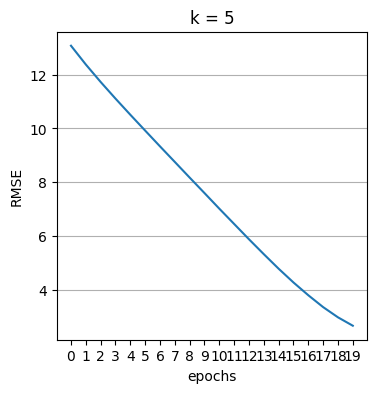

In [ ]:
hybrid_5 = hybrid_neural_network(num_users, num_movie, emb_size=5)
hybrid_5
mse_train = []
hybrid_epochs(hybrid_5, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(5)

Iteration: 10 ; error = 7.4674
Iteration: 20 ; error = 1.7775
test loss 1.599 


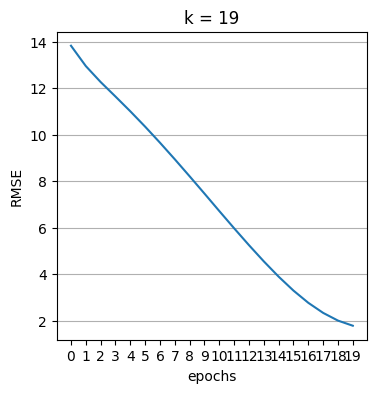

In [ ]:
hybrid_19 = hybrid_neural_network(num_users, num_movie, emb_size=19)
hybrid_19
mse_train = []
hybrid_epochs(hybrid_19, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(19)

Iteration: 10 ; error = 2.9902
Iteration: 20 ; error = 1.7566
test loss 1.619 


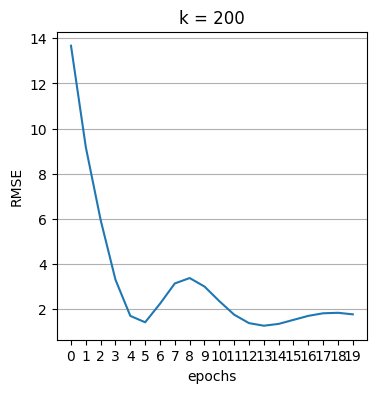

In [ ]:
hybrid_200 = hybrid_neural_network(num_users, num_movie, emb_size=200)
hybrid_200
mse_train = []
hybrid_epochs(hybrid_200, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(200)

Iteration: 10 ; error = 1.5238
Iteration: 20 ; error = 1.4604
test loss 1.547 


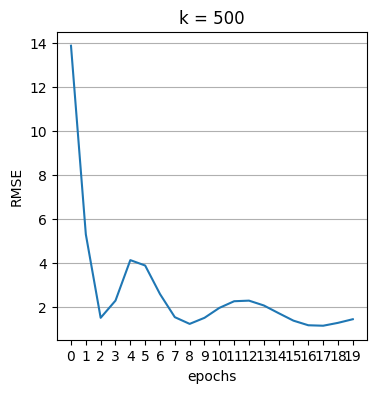

In [ ]:
hybrid_500 = hybrid_neural_network(num_users, num_movie, emb_size=500)
hybrid_500
mse_train = []
hybrid_epochs(hybrid_500, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(500)

Iteration: 10 ; error = 1.3131
Iteration: 20 ; error = 1.0334
test loss 1.033 


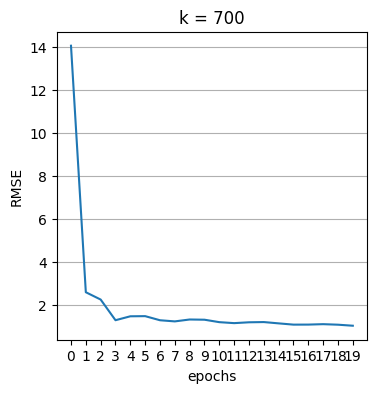

In [ ]:
hybrid_700 = hybrid_neural_network(num_users, num_movie, emb_size=700)
hybrid_700
mse_train = []
hybrid_epochs(hybrid_700, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(700)

Iteration: 10 ; error = 1.4140
Iteration: 20 ; error = 1.4183
test loss 1.601 


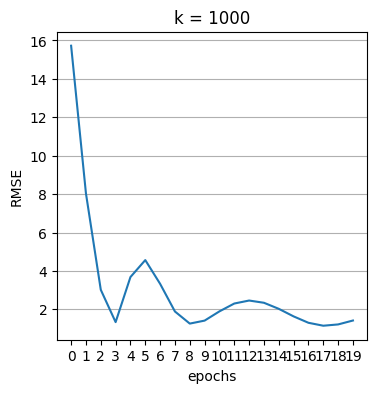

In [ ]:
hybrid_1000 = hybrid_neural_network(num_users, num_movie, emb_size=1000)
hybrid_1000
mse_train = []
hybrid_epochs(hybrid_1000, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(1000)

Iteration: 10 ; error = 3.7048
Iteration: 20 ; error = 1.4905
test loss 1.212 


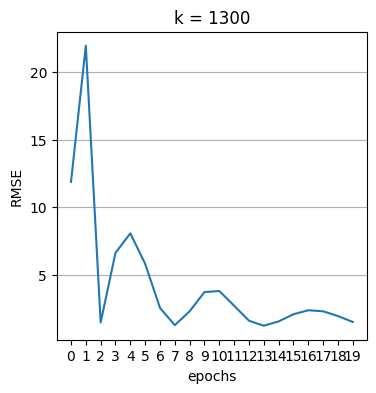

In [ ]:
hybrid_1300 = hybrid_neural_network(num_users, num_movie, emb_size=1300)
hybrid_1300
mse_train = []
hybrid_epochs(hybrid_1300, epochs=20, lr=0.01, wd=1e-6, unsqueeze=True)
plot_RMSE(1300)

In [ ]:
def hybrid_reco_movies(user_id, hybrid_original_df, hybrid_model, user_rating_df, movie_info_df, reco_num=5 ):
  usr_data_hybrid = hybrid_original_df[hybrid_original_df.user_id == user_id].to_numpy()
  recommended_val = hybrid_model(torch.LongTensor(usr_data_hybrid[:,0]),torch.LongTensor(usr_data_hybrid)).detach().numpy().reshape(-1)
  index_val =  np.argsort(recommended_val)[-10:][::-1]
  recommended_item_id= user_rating_df['item_id'].unique()[index_val]  # taking top 10
  recommended_movies_hybrid = movie_info_df.iloc[recommended_item_id]

  return recommended_movies_hybrid

In [ ]:
recommended_movies_hybrid = hybrid_reco_movies(1, hybrid_dataframe, hybrid_700, data_df, item_df2, 10)
recommended_movies_hybrid

movie_title  \
275                     Sense and Sensibility (1995)   
769                                     Congo (1995)   
96                 Terminator 2: Judgment Day (1991)   
565                     Village of the Damned (1995)   
402                                     Ghost (1990)   
154              Monty Python's Life of Brian (1979)   
119           Maya Lin: A Strong Clear Vision (1994)   
696                                 City Hall (1996)   
747                              Benny & Joon (1993)   
650  Seventh Seal, The (Sjunde inseglet, Det) (1957)   

                                    Genre  
275                      [Drama, Romance]  
769  [Action, Adventure, Mystery, Sci-Fi]  
96             [Action, Sci-Fi, Thriller]  
565                    [Horror, Thriller]  
402           [Comedy, Romance, Thriller]  
154                              [Comedy]  
119                         [Documentary]  
696                     [Drama, Thriller]  
747                     [Comedy, Romance]  
650                               [Drama]